# **Imports**

In [ ]:
import os
import glob
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']  = '2' # Message for 'AVX2 AVX_VNNI FMA'
# Importar 'pad_sequences' luego de setear las variables de entorno
import keras
# from keras import regularizers
from keras.utils import pad_sequences
from keras.models import Sequential, Model
from keras.callbacks import Callback, EarlyStopping
from keras.layers import Input, InputLayer, Embedding, Dense, BatchNormalization, Conv1D, GlobalMaxPooling1D, GlobalAveragePooling1D, Lambda, Concatenate
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

> 2025-09-12 17:40:02.086521: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

> 2025-09-12 17:40:02.123636: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.

> To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

> 2025-09-12 17:40:05.381473: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.

# **Dataset**

In [452]:
dataset = pd.read_csv("../../data/2025-09_cdrna_sequences_clean.tsv.gz", sep="\t")

<Axes: title={'center': 'RNA types in CoDNaS-RNA dataset'}, xlabel='RNA type', ylabel='Count'>

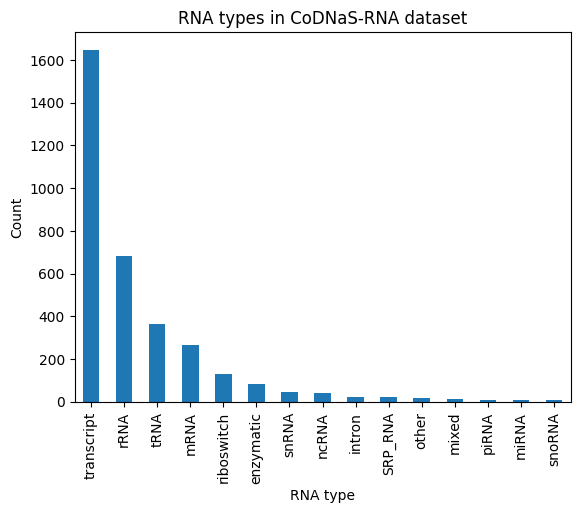

In [453]:
dataset.rna_type_cdrna.value_counts(dropna=False).plot(kind='bar', title='RNA types in CoDNaS-RNA dataset', xlabel='RNA type', ylabel='Count')


In [454]:
dataset = dataset[dataset['rna_type_cdrna'].map((dataset['rna_type_cdrna'].value_counts()) > 49) & (dataset['rna_type_cdrna'] != 'transcript')]

<Axes: title={'center': 'RNA types in CoDNaS-RNA dataset'}, xlabel='RNA type', ylabel='Count'>

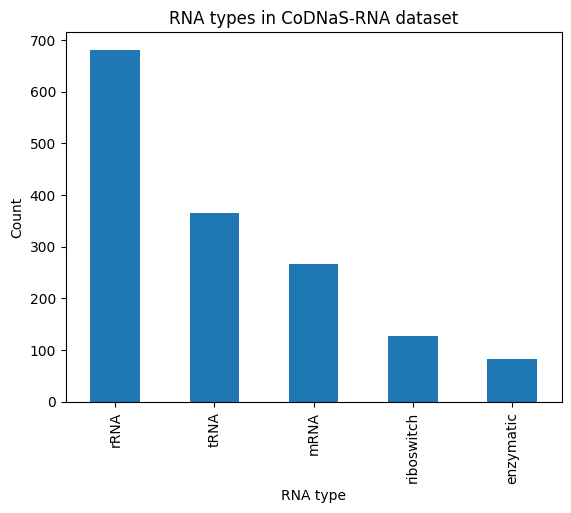

In [526]:
dataset.rna_type_cdrna.value_counts(dropna=False).plot(kind='bar', title='RNA types in CoDNaS-RNA dataset', xlabel='RNA type', ylabel='Count')


## Procesamiento

In [455]:
bases = set().union(*dataset.seqres_can.map(set))
max_length = dataset.seqres_can.map(len).max()

In [456]:
bases

{'A', 'C', 'F', 'G', 'I', 'M', 'N', 'U', 'W', 'X'}

In [457]:
max_length

np.int64(5227)

<Axes: title={'center': 'Sequence Length Distribution'}, xlabel='Sequence Length', ylabel='Frequency'>

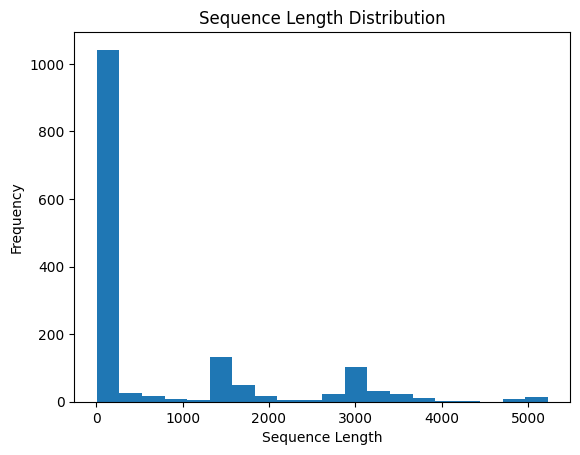

In [527]:
# Length distribution
dataset.seqres_can.map(len).plot.hist(bins=20, xlabel="Sequence Length", title="Sequence Length Distribution")

In [459]:
dataset.seqres_can.map(len).describe()

count    1523.000000
mean      760.276428
std      1180.367143
min        10.000000
25%        57.000000
50%        88.000000
75%      1517.500000
max      5227.000000
Name: seqres_can, dtype: float64

## **Separación**

In [ ]:
# Separamos los datos en train y test
# El 20% de los datos para test
# Oficial doc: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
x_data_train, x_data_test, y_data_train, y_data_test = train_test_split(  dataset.seqres_can        # sequence of indexables with same length / shape[0]
                                                                        , dataset.rna_type_cdrna    # Labels for the data
                                                                        , test_size    = 0.2        # represent the proportion of the dataset to include in the test split
                                                                        , stratify     = dataset.rna_type_cdrna  # Ensures that the split is stratified based on the target variable
                                                                        , shuffle      = True       # Whether or not to shuffle the data before splitting.
                                                                        , random_state = 42 )       # Controls the shuffling applied to the data before applying the split.

In [461]:
x_data_train.shape, x_data_test.shape

((1218,), (305,))

In [462]:
print(f"Number of unique RNA types in training set: {y_data_train.nunique()}")
print(f"Number of unique RNA types in test set: {y_data_test.nunique()}")

Number of unique RNA types in training set: 5
Number of unique RNA types in test set: 5


In [463]:
print(f"Largest RNA sequence in training set: {x_data_train.map(len).max()}")
print(f"Largest RNA sequence in test set: {x_data_test.map(len).max()}")

Largest RNA sequence in training set: 5227
Largest RNA sequence in test set: 5070


In [464]:
y_data_train.value_counts(dropna=False)

rna_type_cdrna
rRNA          545
tRNA          293
mRNA          213
riboswitch    102
enzymatic      65
Name: count, dtype: int64

In [465]:
y_data_test.value_counts(dropna=False)

rna_type_cdrna
rRNA          136
tRNA           73
mRNA           53
riboswitch     26
enzymatic      17
Name: count, dtype: int64

### **Secuencias**

#### [NO USADO] - Convertir secuencias a one-hot encoding

In [ ]:
def one_hot_seq_encode(sequence: str, map_onehot=dict) -> np.ndarray:
    """
    One-hot encodes a sequence using a provided mapping.

    Parameters:

                * sequence (str): The sequence to encode
                * map_onehot (dict): The residue mapping for one-hot encoding (keys are one-letter residues in uppercase, values are lists of 0s and 1s)

    Returns: np.ndarray
    """
    assert isinstance(sequence, str), "Sequence must be a string"
    assert isinstance(map_onehot, dict), "Mapping must be a dictionary"
    assert all(isinstance(v, list) and len(v) == len(map_onehot) for v in map_onehot.values()), "All mapping values must be lists and have the same length"
    assert all(isinstance(i, int) and i in (0, 1) for v in map_onehot.values() for i in v), "All mapping values must be lists of 0s and 1s"
    assert len(sequence) > 0, "Given sequence must not be empty"
    sequence = sequence.upper()
    assert all(r in map_onehot for r in sequence), "All residues must be in the mapping"

    return np.array([map_onehot.get(residue, [0] * len(map_onehot)) for residue in sequence])


In [6]:
# Count types of bases
dataset.seqres_can.str.split('').explode().value_counts(normalize=False, dropna=False).drop(labels=[''])

seqres_can
G    383183
C    303932
A    302107
U    256439
X        36
N        11
I         8
F         3
W         3
M         1
Name: count, dtype: int64

In [7]:
map_onehot = {}
for i, base in enumerate(bases):
    map_onehot[base] = np.zeros(len(bases), dtype=int).tolist()
    map_onehot[base][i] = 1

In [8]:
map_onehot

{'U': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'G': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 'C': [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 'X': [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
 'A': [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
 'F': [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 'N': [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 'W': [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 'I': [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 'M': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [9]:
len(map_onehot)

10

In [11]:
# Matrix of one-hot encoding using the mapping :)
one_hot_seq_encode(sequence=''.join(map_onehot.keys()), map_onehot=map_onehot)

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]])

#### Convertir secuencias a embeddings

In [466]:
def embed_sequence(sequence: str, map_residues: dict) -> list[int]:
    """
    Embeds a sequence using a provided mapping.
    If a residue is not found in the mapping, it is replaced with 0.

    Parameters:

        * sequence (str): The sequence to embed
        * map_residues (dict): The residue mapping for embedding (keys are one-letter residues in uppercase, values are embedding vectors)

    Returns: list[int]
    """
    assert isinstance(sequence, str), "Sequence must be a string"
    assert isinstance(map_residues, dict), "Mapping must be a dictionary"
    assert len(sequence) > 0, "Given sequence must not be empty"
    sequence = sequence.upper()

    return [map_residues.get(residue, 0) for residue in sequence]

In [467]:
map_residues = {base: n for n, base in enumerate(bases, 1)}

In [468]:
embed_sequence(sequence=''.join(map_residues.keys()), map_residues=map_residues)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

#### Padding de secuencias
Secuencia más larga como referencia para padding

In [469]:
sequences_train_embed = [embed_sequence(seq, map_residues) for seq in x_data_train]
sequences_train_embed_padded = pad_sequences(sequences_train_embed, maxlen=max_length, padding='post', truncating='post')

sequences_test_embed = [embed_sequence(seq, map_residues) for seq in x_data_test]
sequences_test_embed_padded = pad_sequences(sequences_test_embed, maxlen=max_length, padding='post', truncating='post')

In [470]:
len(sequences_train_embed)

1218

In [471]:
print(f"First: {len(sequences_train_embed[0])}")
print(f"Last: {len(sequences_train_embed[-1])}")

First: 78
Last: 74


In [472]:
sequences_train_embed_padded.shape

(1218, 5227)

In [473]:
print(f"First: {len(sequences_train_embed_padded[0])}")
print(f"Last: {len(sequences_train_embed_padded[-1])}")

First: 5227
Last: 5227


In [474]:
# analizar la distribución de longitudes para definir un maxlen que cubra, por ejemplo, el 90% de las secuencias sin perder demasiada información
x_data_train.map(len).describe()

count    1218.000000
mean      756.041872
std      1175.129713
min        10.000000
25%        58.000000
50%        87.500000
75%      1517.000000
max      5227.000000
Name: seqres_can, dtype: float64

In [475]:
# get upto 90th percentile of distribution of sequence lengths
x_data_train.map(len).quantile(0.9)

np.float64(2905.3)

In [476]:
# get between 30 upto 90th percentile of distribution of sequence lengths
x_data_train.map(len).quantile(0.3), x_data_train.map(len).quantile(0.9)
x_data_train[   (x_data_train.map(len) >= x_data_train.map(len).quantile(0.3)) &\
                (x_data_train.map(len) <= x_data_train.map(len).quantile(0.9)) ].shape

(733,)

In [477]:
x_data_train[(x_data_train.map(len) > 1640)].shape


(228,)

### **Etiquetas**

#### Codificación categórica: convertir los tipos de RNA (texto) a números
Se muestran 2 formas de hacerlo: una manual (elegida) y otra utilizando `sklearn`.

##### Utilizando `sklearn`

In [478]:
# Initialize the label encoder
label_encoder = LabelEncoder()
label_encoder.fit(y_data_train.tolist())

# Transform the labels
labels = label_encoder.transform(y_data_train.tolist())

##### Utilizando `dict` (manual)

In [479]:
# Custom label encoder
data = dataset.rna_type_cdrna.tolist()
classes = sorted(set(data))

class_index = dict(zip(classes, range(len(classes))))
index_class = dict(zip(range(len(classes)), classes))
y_train_labels = list(map(class_index.get, y_data_train))
y_test_labels = list(map(class_index.get, y_data_test))

In [480]:
class_index

{'enzymatic': 0, 'mRNA': 1, 'rRNA': 2, 'riboswitch': 3, 'tRNA': 4}

In [481]:
index_class

{0: 'enzymatic', 1: 'mRNA', 2: 'rRNA', 3: 'riboswitch', 4: 'tRNA'}

In [482]:
# Get key with value '4'
print({k: v for k, v in class_index.items() if v == 4}) # Dificil. Usa un bucle y es lento

# Get value of key '4'
print(index_class[4])  # Super fácil y rápido. Usa un poquito de memoria porque requiere definir un dict extra

# Map the encoded labels back to the original labels
print(label_encoder.inverse_transform([4])) # Fácil pero requiere sklearn y es una lista con único elemento

{'tRNA': 4}
tRNA
['tRNA']


### **Balanceo de clases**

Existen 15 tipos de RNA en el dataset y están fuertemente desbalanceados.
Queremos que no haya un bias a los tipos mayoritarios, por lo que vamos a usar pesos de clase para balancear el aprendizaje en el entrenamiento.

In [483]:
# Pesos de las clases
# https://datascience.stackexchange.com/a/18722
class_weights  =  compute_class_weight( class_weight ='balanced'
                                    ,   classes      = np.unique(y_train_labels)
                                    ,   y            = y_train_labels )

In [484]:
class_weight_dict = dict(enumerate(class_weights))

# **Creación del modelo**

### **Arquitectura**

In [485]:
vocab_size   = len(map_residues) + 1   # +1 para el padding (0)
input_length = max_length              # Longitud máxima de las secuencias de entrada
nb_classes   = len(classes)            # Número de clases de salida

In [529]:
# Inicialización del modelo
if 'model' in locals():
    del model

model = Sequential(name="RNA_Type_Classifier")

# Capa de entrada que define la forma de los datos de entrada
model.add(Input(shape=(input_length,), dtype=tf.int32))

# Capa Embedding: https://keras.io/api/layers/core_layers/embedding/
# CUIDADO: documentación oficial está desactualizada:
# - https://github.com/keras-team/keras/issues/19282
# - No existe más el parámetro 'input_length'
# Solución: ahora se infiere: https://github.com/keras-team/keras/issues/19094#issuecomment-1909387912
# , input_length           = input_length   # Longitud máxima de las secuencias de entrada
model.add(Embedding(  input_dim              = vocab_size     # Dimensión del vocabulario (número de tokens únicos + 1 por el padding)
                    , output_dim             = 64             # Dimensión del embedding (ajustable). Se fija en 64 porque el vocabulario es pequeño y no se necesita un embedding muy grande. Además ayuda a no consumir tanta memoria.
                    , mask_zero              = False           # Capas que puedan ignorar el 0 por padding
                    , embeddings_initializer = 'uniform'      # Por defecto: inicialización uniforme de los pesos del embedding
                    , name                   = 'embedding_layer' ))
# Cada lote de N secuencias tiene forma (N, input_length, 64 embeddings) y se aplana a (N, input_length * 64)
# model.add(Flatten(name="flatten_layer"))

# model.add(Conv1D(filters=128, kernel_size=9, activation='relu', padding='same', name="conv1d_1"))
# model.add(BatchNormalization(name="batch_norm_1"))

model.add(Conv1D(filters=128, kernel_size=5, activation='relu', padding='same', name="conv1d_2"))
model.add(BatchNormalization(name="batch_norm_2"))

# Capa de pooling avg global + max
# Esta capa reduce la dimensionalidad de la salida de la capa de embedding
# pasa de gran dimensionalidad (N, input_length, 64) a (N, 64), siendo N el tamaño del lote.
# model.add(GlobalAveragePooling1D(name="global_avg_pooling_1", data_format="channels_last"))

# Capa de pooling max global
# NOTA: sin capas conv no detecta los patrones. Accuracy peor que con GlobalAveragePooling1D
model.add(GlobalMaxPooling1D(name="global_max_pooling_1", data_format="channels_last"))
model.add(BatchNormalization(name="batch_norm_3"))

# capas GAP + GMP concatenado usando Lambda
# model.add(Lambda(lambda x: Concatenate()([
#     GlobalAveragePooling1D()(x),
#     GlobalMaxPooling1D()(x)
# ])))
# model.add(BatchNormalization(name="batch_norm_3"))


# model.add(Dense(units=256, activation='relu', kernel_initializer='he_uniform', name="dense_1"))
# model.add(BatchNormalization(name="batch_norm_4"))

# model.add(Dense(units=128, activation='relu', kernel_initializer='he_uniform', name="dense_2"))
# model.add(BatchNormalization(name="batch_norm_5"))

# Feed-forward - Capa oculta
# Cantidad de hiperparámetros por lote de N:
# (N * input_length * 64) * 128 + 128 (bias) = (N * 45495808) + 128 = (N * 45495936)
# Si N es total, N=3361, son 152.911.840.896 parámetros
# Si N=32, son 1.455.869.952 parámetros por lote.
# Si N=16, son 727.934.976 parámetros por lote.
model.add(Dense(units=64, activation='relu', kernel_initializer='he_uniform', name="dense_3"))
model.add(BatchNormalization(name="batch_norm_6"))

# Feed-forward - Segunda capa oculta
model.add(Dense(units=32, activation='relu', kernel_initializer='he_uniform', name="dense_4"))
model.add(BatchNormalization(name="batch_norm_7"))

# Capa de salida usando softmax
# Tiene tantas neuronas como clases espero
model.add(Dense(units=nb_classes, activation='softmax', name="output_layer"))


#### Optimizador

In [530]:
# API : https://keras.io/api/optimizers/
# learning_rate es el 'alpha'
alpha = 0.0001 # Valor por defecto en Adam, 0.001
opt = keras.optimizers.Adam(learning_rate=alpha) # ADAM = AdaGrad + Momentum

#### Métricas

In [531]:
# Accuracy metrics
# Accuracy : https://keras.io/api/metrics/accuracy_metrics/#accuracy-class

# Classification metrics based on True/False positives & negatives
# F1 : https://keras.io/api/metrics/classification_metrics/#f1score-class

# Metrics for each class
metrics = [ keras.metrics.SparseCategoricalAccuracy(name='accuracy') ]

# metrics.extend([
#     # Precision and Recall for each class
#     keras.metrics.Precision(class_id=class_id, name=f'precision_class_{class_id}_{index_class[class_id].replace(" ", "_")}')
#     for class_id in class_index.values()
# ] + [
#     keras.metrics.Recall(class_id=class_id, name=f'recall_class_{class_id}_{index_class[class_id].replace(" ", "_")}')
#     for class_id in class_index.values()
# ])


### **Compilación**

In [532]:
model.compile( loss      = 'sparse_categorical_crossentropy' # Función de pérdida para codificación categórica de enteros
            ,  optimizer = opt                               # Usa el optimizador Adam con valores por defecto. Podría haberse usado 'adam' directamente
            ,  metrics   = metrics )

### **Monitoreo**

In [533]:
def plot_metric(history: 'keras.src.callbacks.history.History', metric: str) -> None:
    """
    Plots the training and validation metric over epochs.

    Parameters:

            * history:      The Keras history object returned by model.fit()
            * metric:       a string. The name of the metric to plot

    Returns: nothing
    """
    plt.grid(False)
    plt.plot(history.history[metric], label='Training ' + metric)
    plt.plot(history.history['val_' + metric], label='Validation ' + metric)
    plt.title(f'Training and Validation {metric.capitalize()} Over Epochs')
    plt.ylabel(metric)
    plt.xlabel('Epochs')
    plt.legend(loc='best')
    plt.show()

In [534]:
# Callbacks
# https://keras.io/api/callbacks/early_stopping/#earlystopping-class

monitor_metric  = 'val_loss'
patience        = 15
min_delta       = 0.001

early_stopping = EarlyStopping( monitor              = monitor_metric # Quantity to be monitored. (default: 'val_loss')
                            ,   verbose              = 1          # Verbosity mode, 0 or 1. Mode 0 is silent, and mode 1 displays messages when the callback takes an action. Defaults to 0.
                            ,   patience             = patience         # Number of epochs with no improvement after which training will be stopped
                            ,   restore_best_weights = True       # Whether to restore model weights from the epoch with the best value of the monitored quantity.
                            ,   min_delta            = min_delta )    # Minimum change in the monitored quantity to qualify as an improvement

callbacks = [early_stopping]

### **Resumen del modelo**

In [535]:
model.summary()

Model: "RNA_Type_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 5227, 64)       │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5227, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_2                    │ (None, 5227, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling_1            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_3                    │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_6                    │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_norm_7                    │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,701 (209.77 KB)

 Trainable params: 52,997 (207.02 KB)

 Non-trainable params: 704 (2.75 KB)

### **Entrenamiento**

#### Uso de lotes (batches)

In [536]:
batch_size = 16
num_epochs = 100

In [537]:
history  =  model.fit( x                = sequences_train_embed_padded  # Secuencias con padding para entrenamiento
                    ,  y                = np.array(y_train_labels)      # Etiquetas para entrenamiento
                    ,  batch_size       = batch_size                    # Tamaño del lote de entrenamiento. Esto es arbitrario. Uso 32 secuencias para cada lote por motivos de memoria y rendimiento.
                    ,  epochs           = num_epochs                    # Número de épocas
                    ,  verbose          = True                          # Verbosidad del entrenamiento
                    ,  validation_data  = (sequences_test_embed_padded, np.array(y_test_labels))  # Datos de test para validación
                    ,  class_weight     = class_weight_dict             # Diccionario de balanceo (sección 'Balanceo de clases')
                    ,  callbacks        = callbacks )                   # Lista de callbacks para monitoreo del entrenamiento


Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.3350 - loss: 1.7832 - val_accuracy: 0.2393 - val_loss: 1.5842
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5632 - loss: 1.2040 - val_accuracy: 0.2525 - val_loss: 1.9115
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6478 - loss: 1.0211 - val_accuracy: 0.1738 - val_loss: 2.5490
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6847 - loss: 0.9081 - val_accuracy: 0.1738 - val_loss: 3.1306
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7151 - loss: 0.8103 - val_accuracy: 0.1738 - val_loss: 3.6001
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7471 - loss: 0.7480 - val_accuracy: 0.1738 - val_loss: 3.7320
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7570 - loss: 0.7174 - val_accuracy: 0.1738 - val_loss: 3.5381
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7718 - loss: 0.6527 - val_accuracy: 0.

### **Evaluación**

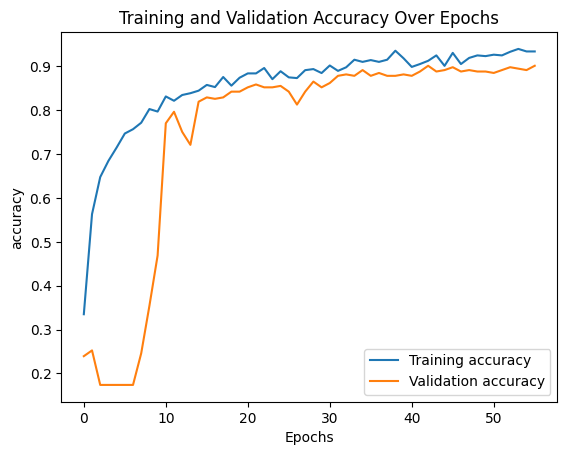

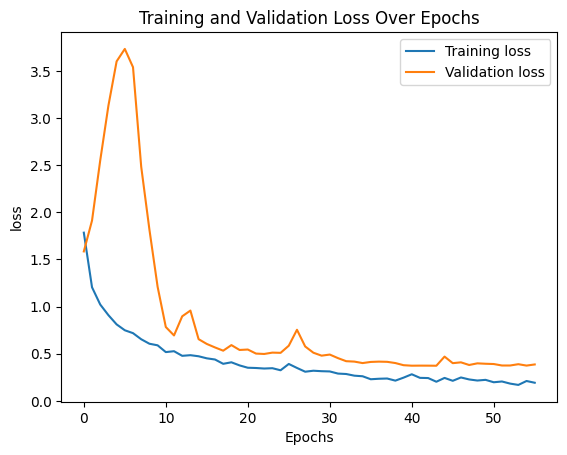

In [538]:
plot_metric(history, 'accuracy')
plot_metric(history, 'loss')

### **Predicción**

In [569]:
result = model.predict(sequences_test_embed_padded)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [540]:
print(f"Expected, predicted")
count = 0
for i, expected in enumerate(y_data_test):
    predicted_class = np.argmax(result[i])
    predicted_class_name = index_class[predicted_class]
    if expected == predicted_class_name:
        count += 1
    # else:
    #     print(f"index {i}: {expected}, {predicted_class_name}")
print(f"Total correct predictions: {count} out of {len(y_data_test)}")

Expected, predicted
Total correct predictions: 268 out of 305


In [ ]:
# Ejemplo para one-hot con umbral 0.2 para matriz de confusión
cutoff = 0.2
result_classes = np.where((result >= cutoff), 1, 0)
correct = (result_classes.sum(axis=1) == 1).sum()
fraction = f"{correct}/{result_classes.shape[0]}"
perc = (result_classes.sum(axis=1) == 1).sum() / result_classes.shape[0] * 100
print(f"Accuracy with cutoff '{cutoff}': {perc:.2f}%, {correct} out of {result_classes.shape[0]}")


Accuracy with cutoff '0.2': 85.90%, 262 out of 305


In [ ]:
# y_true and y_pred must be defined as before
y_true = np.array(y_test_labels)
y_pred = np.argmax(result, axis=1)

#### [WIP] - Métricas usando dataclass

In [ ]:
# Collect metrics for each RNA Type
# dataclass
class RNATypeMetricsCollector:
    def __init__(self, class_id, rna_type) -> None:
        self.class_id = class_id
        self.rna_type = rna_type
        self.metrics_dict = {
            "sens": [],
            "spec": [],
            "prec": [],
            "rec": [],
            "f1": [],
            "roc_auc": [],
            "acc": [],
            "class_name": []
        }

    def get_class_id(self) -> dict:
        return self.class_id

    def get_type(self) -> dict:
        return self.rna_type

    def collect_metrics(self, y_true, y_pred) -> None:
        y_true_bin = (y_true == self.class_id).astype(int)
        y_pred_bin = (y_pred == self.class_id).astype(int)
        if np.sum(y_true_bin) > 0:
            tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin).ravel()

            sens = tp/(tp+fn) if (tp+fn) > 0 else 0
            spec = tn/(fp+tn) if (fp+tn) > 0 else 0
            prec = tp/(tp+fp) if (tp+fp) > 0 else 0
            f1v = f1_score(y_true_bin, y_pred_bin)
            acc = accuracy_score(y_true_bin, y_pred_bin)
            roc_auc = roc_auc_score(y_true_bin, y_pred_bin)

            self.metrics_dict["sens"].append(sens)
            self.metrics_dict["spec"].append(spec)
            self.metrics_dict["prec"].append(prec)
            self.metrics_dict["rec"].append(rec)
            self.metrics_dict["f1"].append(f1v)
            self.metrics_dict["roc_auc"].append(roc_auc)
            self.metrics_dict["acc"].append(acc)
            self.metrics_dict["class_name"].append(rna_type)
        else:
            # If class not present, append NaN
            for k in ["sens", "spec", "prec", "rec", "f1", "roc_auc", "acc"]:
                self.metrics_dict[k].append(np.nan)
                self.metrics_dict["class_name"].append(rna_type)

    def get_metrics(self) -> pd.DataFrame:
        return pd.DataFrame(self.metrics_dict)


In [ ]:
rna_type_metrics = [RNATypeMetricsCollector(class_id, class_name) for class_id, class_name in index_class.items()]

rna_types_metrics = [rna_type.collect_metrics(y_true, y_pred) for rna_type in rna_type_metrics]

In [ ]:
# Plot using 'rna_types_metrics'



#### Métricas

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score

In [649]:
# Otra forma sin dataclasses
metrics_dict = {
            "sens": [],
            "spec": [],
            "prec": [],
            "rec": [],
            "f1": [],
            "roc_auc": [],
            "acc": [],
            "class_name": []
        }


for class_id, class_name in index_class.items():

    y_true_bin = (y_true == class_id).astype(int)
    y_pred_bin = (y_pred == class_id).astype(int)
    if np.sum(y_true_bin) > 0:
        tn, fp, fn, tp = confusion_matrix(y_true_bin, y_pred_bin).ravel()

        sens = tp/(tp+fn) if (tp+fn) > 0 else 0
        spec = tn/(fp+tn) if (fp+tn) > 0 else 0
        prec = tp/(tp+fp) if (tp+fp) > 0 else 0
        rec = tp/(tp+fn) if (tp+fn) > 0 else 0
        f1v = f1_score(y_true_bin, y_pred_bin)
        acc = accuracy_score(y_true_bin, y_pred_bin)
        roc_auc = roc_auc_score(y_true_bin, y_pred_bin)

        metrics_dict["sens"].append(sens)
        metrics_dict["spec"].append(spec)
        metrics_dict["prec"].append(prec)
        metrics_dict["rec"].append(rec)
        metrics_dict["f1"].append(f1v)
        metrics_dict["roc_auc"].append(roc_auc)
        metrics_dict["acc"].append(acc)
    else:
        # If class not present, append NaN
        for k in ["sens", "spec", "prec", "rec", "f1", "roc_auc", "acc"]:
            metrics_dict[k].append(np.nan)
    metrics_dict["class_name"].append(class_name)

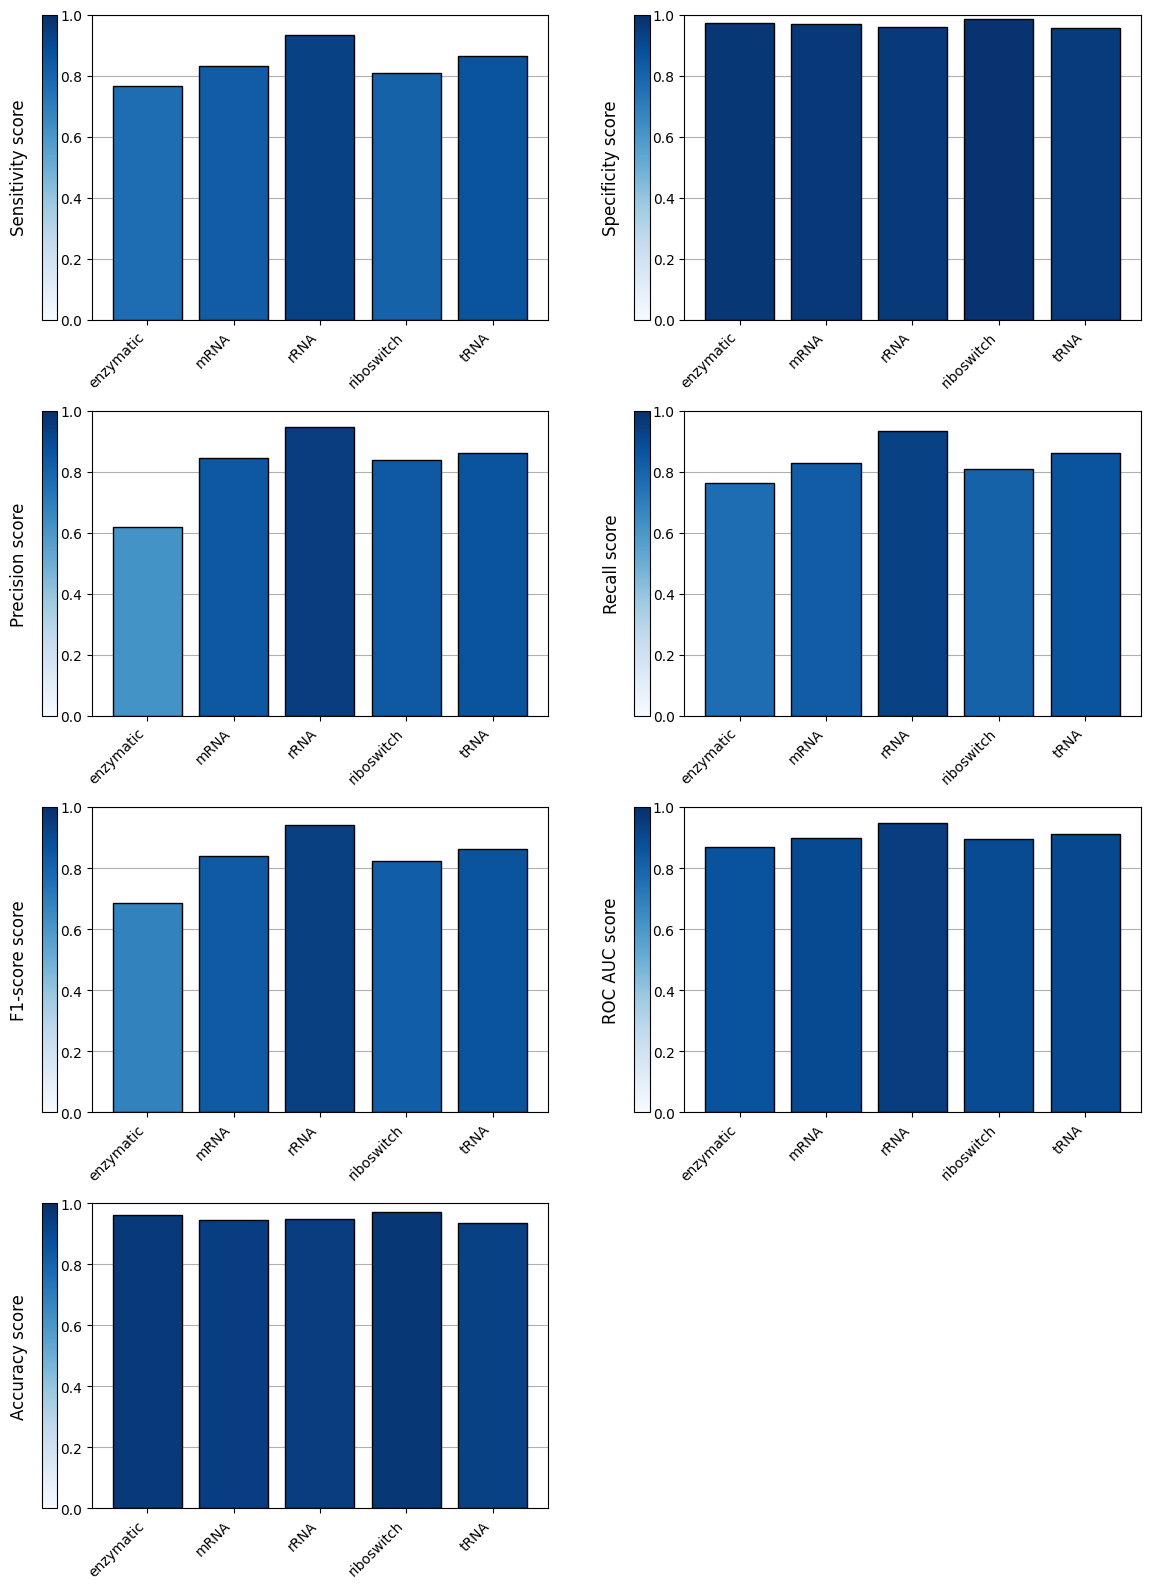

In [ ]:
# Plot all metrics in one figure with multiple axes
metric_names = ["sens", "spec", "prec",  "rec", "f1", "roc_auc", "acc"]
titles = ["Sensitivity", "Specificity", "Precision", "Recall", "F1-score", "ROC AUC", "Accuracy"]
nb_columns = 2
nb_rows = len(metric_names) // nb_columns + int(len(metric_names) % nb_columns > 0)
fig, axes = plt.subplots(nb_rows, nb_columns, figsize=(12, nb_rows * 4))
axes = axes.flatten()[:len(metric_names)+1]  # Flatten and keep only the needed axes

# Remove last axes if nb of axes is odd
if len(metric_names) % nb_columns != 0:
    fig.delaxes(axes[-1])


x = np.arange(len(metrics_dict["class_name"]))
cmap = plt.cm.Blues  # white to light blue

for i, (ax, m, title) in enumerate(zip(axes, metric_names, titles)):
    scores = np.array(metrics_dict[m])
    # Normalize scores for colormap (0=white, 1=light blue)
    norm = plt.Normalize(0, 1)
    colors = cmap(norm(scores))
    bars = ax.bar(x, scores, color=colors, edgecolor='black')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics_dict["class_name"], rotation=45, ha='right')
    # Define colorbar as y
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, location='left', pad=0.06)
    cbar.set_label(f'{title} score', rotation=90, labelpad=10, size=12)
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_ticks([])
    ax.set_ylim(0, 1)
    # Grid behind bars
    ax.grid(True, axis='y')
    ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

# **Almacenamiento del modelo**

Documentación oficial:
- https://keras.io/guides/serialization_and_saving/
- https://keras.io/api/models/model_saving_apis/model_saving_and_loading/#whole-model-saving-amp-loading

Keras soporta el formato HDF5 para guardar modelos completos. También soporta el formato 'tf' (TensorFlow SavedModel)  
HDF5 es un formato de archivo que permite almacenar grandes cantidades de datos de manera eficiente.  

Un archivo HDF5 contiene:
- Los pesos del modelo.
- La arquitectura del modelo, permitiendo recrear el modelo.

In [542]:
# Time format: YYYYMMDD-HHMMSS
dt = datetime.now().strftime("%Y%m%d-%H%M%S")
day, time = dt.split("-")
dirpath = f"../../results/models/{day}/{time}"
os.makedirs(dirpath, exist_ok=True)

### Almacenamiento métricas del modelo

In [543]:
def save_plot_metric(filepath: str, metric: str, history: dict, model_name: str = None) -> None:
    """
    Save a plot of the specified metric from the training history.

    Parameters:

                * filepath:         The path to save the plot.
                * metric:           The name of the metric to plot (e.g., 'accuracy', 'loss').
                * history:          The training history containing metric values.
                * model_name:       The name of the model (optional).

    Returns: nothing
    """
    plt.figure()
    plt.grid(False)
    plt.plot(history[metric], label=f"Training")
    if f'val_{metric}' in history:
        plt.plot(history[f'val_{metric}'], label=f"Validation")
    plt.xlabel('Epoch')
    plt.ylabel(metric.capitalize())
    plt.legend(loc='best')
    plt.title(f"'{model_name}' - '{metric}' over epochs") if model_name is not None else plt.title(f"Model '{metric}' over epochs")
    plt.savefig(filepath, dpi=300)
    plt.close()
    return


In [544]:
for metric in ['accuracy', 'loss']:
    save_plot_metric( filepath   = f"{dirpath}/{dt}_rna_classifier_model_{metric}.png"
                    , history    = history.history
                    , metric     = metric
                    , model_name = 'RNA Type Classifier')

### Almacenamiento del modelo

In [545]:
model.save(filepath    = f"{dirpath}/{dt}_rna_classifier_model.keras"
        # ,  save_format = 'h5'       # WARNING:absl:The `save_format` argument is deprecated in Keras 3. We recommend removing this argument as it can be inferred from the file path. Received: save_format=h5
        ,  zipped      = True       # Whether to save the model as a zipped .keras archive (default when saving locally), or as an unzipped directory (default when saving on the Hugging Face Hub).
        ,  overwrite   = True )

### Almacenamiento de pesos

In [546]:
# https://keras.io/api/models/model_saving_apis/weights_saving_and_loading/#saveweights-method
model.save_weights(filepath       = f"{dirpath}/{dt}_rna_classifier_model.weights.h5"
                ,  overwrite      = True
                ,  max_shard_size = None)       # If not None, the weights will be saved in multiple shards of up to max_shard_size GB each.

### Almacenamiento de arquitectura

In [547]:
with open(f"{dirpath}/{dt}_rna_classifier_model_architecture.json", "w") as json_file:
    json_file.write(model.to_json())

# **Reporte**

In [548]:
print(history.params)
print(history.model)
print(f"Max epoch: {max(history.epoch)}")
print(f"Metrics: {list(history.history.keys())}")

{'verbose': True, 'epochs': 100, 'steps': 77}
<Sequential name=RNA_Type_Classifier, built=True>
Max epoch: 55
Metrics: ['accuracy', 'loss', 'val_accuracy', 'val_loss']


In [549]:
report_dir = "../../results/"
os.makedirs(report_dir, exist_ok=True)
filepath = f"{report_dir}/training_reports.tsv"

df_run = pd.DataFrame()
df_run["timestamp"]                  = [dt]
df_run["num_classes"]                = [nb_classes]
df_run["vocab_size"]                 = [vocab_size]
df_run["input_length"]               = [input_length]
df_run["learning_rate"]              = [alpha]
df_run["batch_size"]                 = [batch_size]
df_run["num_epochs"]                 = [num_epochs]
df_run["stopped_epoch"]              = [max(history.epoch)]
df_run["num_params"]                 = [model.count_params()]
df_run["early_stopping"]             = ["Yes" if early_stopping in callbacks else "No"]
df_run["monitor"]                    = [monitor_metric if early_stopping in callbacks else "N/A"]
df_run["min_delta"]                  = [min_delta]
df_run["patience"]                   = [patience]
df_run['accuracy']                   = [history.history['accuracy'][-1]]
df_run['val_accuracy']               = [history.history['val_accuracy'][-1]]
df_run['prediction_size']            = [y_data_test.shape[0]]
df_run['prediction_cutoff']          = [cutoff]
df_run['prediction_percent_correct'] = [perc]

for file_png in glob.glob(f"{dirpath}/{dt}*.png"):
    a_metric = os.path.basename(file_png).split("_")[-1].replace(".png", "")
    df_run[f'link_{a_metric}_plot']  = [file_png]

if os.path.exists(filepath):
    # Append to existing file
    df_run.to_csv(filepath, sep="\t", index=False, mode='a', header=False)
else:
    # Create new file
    df_run.to_csv(filepath, sep="\t", index=False)


# **Recupero del modelo**

### Recupero de arquitectura

In [ ]:
# Loads a model saved via model.save()
# https://keras.io/api/models/model_saving_apis/model_saving_and_loading/#loadmodel-function
# model = keras.saving.load_model(f"{dirpath}/{dt}_rna_classifier_model.keras")

### Recupero de pesos

In [ ]:
# https://keras.io/api/models/model_saving_apis/weights_saving_and_loading/#load_weights-method
# NOte: Sharding
# When loading sharded weights, it is important to specify filepath that ends with *.weights.json
# which is used as the configuration file. Additionally, the sharded files *_xxxxx.weights.h5 must
# be in the same directory as the configuration file.

# Model.load_weights(filepath      = f"{dirpath}/{dt}_rna_classifier_model.weights.h5"
#                 ,  skip_mismatch = False )